In [2]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [3]:
fig_scale = 1.#2./3.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap, jit
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [5]:
plt.rcParams['font.size'] = 14

In [6]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[CpuDevice(id=0)]


# Process Data

In [7]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)
c_df.columns = pd.to_datetime(c_df.columns)
d_df.columns = pd.to_datetime(d_df.columns)

[265, 252, 91]


In [8]:
t_df, h_df, w_df = transform.weather(update=False)

In [9]:
t_df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,9.908750,9.908750,9.908750,9.908750,9.908750,9.908750,9.908750,9.908750,9.908750,9.908750,...,11.816250,12.454583,13.411667,13.391667,13.913333,15.768333,17.623750,16.640833,16.598333,18.434167
Albania,6.367500,6.367500,6.367500,6.367500,6.367500,6.367500,6.367500,6.367500,6.367500,6.367500,...,12.433333,13.694167,15.439583,16.323333,17.113750,15.297083,11.196250,9.678333,12.353333,13.328333
Algeria,22.660417,22.660417,22.660417,22.660417,22.660417,22.660417,22.660417,22.660417,22.660417,22.660417,...,25.568750,28.751250,29.854583,18.162083,19.622083,23.264167,24.528333,24.943750,27.750000,27.046667
Andorra,5.491667,5.491667,5.491667,5.491667,5.491667,5.491667,5.491667,5.491667,5.491667,5.491667,...,11.564167,12.428750,13.202083,11.857917,10.310000,9.252917,9.542917,10.220000,11.554583,11.226250
Angola,22.600833,22.600833,22.600833,22.600833,22.600833,22.600833,22.600833,22.600833,22.600833,22.600833,...,22.797083,22.242500,20.467500,20.236667,21.377500,21.418333,21.309167,21.354583,20.740000,21.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sao Tome and Principe,26.849167,27.046250,26.746667,26.637917,26.914167,26.887083,26.918750,27.235833,27.305417,26.985417,...,26.901667,26.365000,26.881250,26.427917,26.024583,26.877500,26.799583,26.986250,26.971667,26.638333
Yemen,18.847500,19.436250,19.207500,20.950417,18.420417,15.058750,11.818333,13.278333,15.695833,16.450417,...,25.880000,26.086250,26.973750,27.342500,27.282083,24.309167,26.421667,27.613750,27.837500,27.724583
Australia,NaN,NaN,18.726094,18.726094,18.726094,18.726094,18.726094,18.726094,18.726094,18.726094,...,18.879062,17.873802,16.852656,16.692760,17.045990,17.339375,17.568594,17.581302,18.202292,18.122344


In [10]:
tests_df = pd.read_csv('../data/test_rate/test_rate_processed.csv', index_col='Country/Region')
tests_df.columns = pd.to_datetime(tests_df.columns)

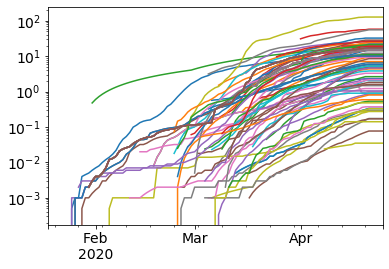

In [11]:
tests_df.T.plot(legend=False, logy=True)

In [12]:
all_countries = tests_df.index.intersection(d_df.index)

In [13]:
len(all_countries)

61

In [13]:
cases = {}
deaths = {}
temps = {}
hums = {}
testsp1k = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if country not in all_countries:
        continue
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            temps[country] = np.nanmean(t_df.T[country].values[time_slice])
            hums[country] = np.nanmean(h_df.T[country].values[time_slice])
            cases[country] = c_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]
        else:
            temps[country] = np.nanmean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.nanmean(h_df.T[country].values[start_days[i]-climate_delay:])
            cases[country] = c_df[d_df.columns[start_days[i]:]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:]].T[country].values
            testsp1k[country] = tests_df[d_df.columns[start_days[i]:]].T[country].values
            if np.isnan(np.nanmax(testsp1k[country])):
                del deaths[country]
                del testsp1k[country]

In [14]:
len(deaths)

56

In [15]:
pops = transform.population()
posp1k = {}
posrate = {}
for c in deaths.keys():
    posp1k[c] = cases[c][-1]/pops[c].values*1000
    posrate[c] = posp1k[c]/np.nanmean(testsp1k[c])*100

[265, 252, 265]
Number of unmatched regions : 75
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [16]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))

In [17]:
print(f'Missing BCG Coverage for : {set(deaths.keys())-set(bcg_cov_est.keys())}')
all_countries = list(set(deaths.keys()).intersection(bcg_cov_est.keys()))

Missing BCG Coverage for : {'Bolivia'}


In [18]:
len(all_countries)

55

In [19]:
theta = {}
for c in all_countries:
    theta[c] = np.array([bcg_cov_est[c], temps[c], hums[c], np.nanmax(testsp1k[c]), posrate[c][0]])

In [20]:
MAX_DAYS = int(max([len(deaths[c]) for c in deaths]))

In [21]:
MAX_DAYS

63

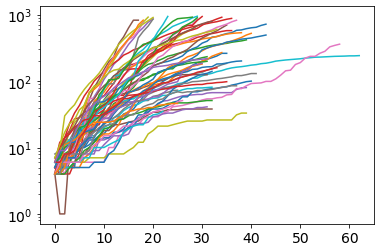

In [22]:
for c in all_countries:
    plt.semilogy(deaths[c])

# Bayesian Model

In [23]:
@jit
def sigmoid(a, t0, t):
    
    return 1.0/(1.0+np.exp(-a*(t-t0)))

@jit
def step_inter(Di, GR1, GR2, a, t0):
        
    t = np.arange(1, MAX_DAYS)
    step = sigmoid(a, t0, t)
    logGR = np.log(np.concatenate([np.array([Di,]), (GR1 + (GR2-GR1)*step)]))
    D = np.exp(np.cumsum(logGR))
    
    return D

In [24]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), 
                                                       grp_sigma*np.ones(N_child)))
    
    return ind

In [25]:
def model():
    
    N = len(all_countries)
#     N_theta = len(theta[list(theta.keys())[0]])
    
    # Initial Deaths
    Di = normalHP('Di', 7.0, 3.0, N)
    # Initial Growth Rate
    GR1 = normalHP('GR1', 1.2, 0.2, N)
    # Final Growth rate
    GR2 = normalHP('GR2', 1.1, 0.2, N)
    # Transition rate
    tr = normalHP('tr', 1.0, 0.5, N)
    # Transition Time
    t0 = normalHP('t0', 15.0, 5.0, N)
    
    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country]
        prediction = step_inter(Di[i], GR1[i], GR2[i], tr[i], t0[i])[:len(dead)]
        numpyro.sample(country, dist.Poisson(prediction), obs=dead)

In [26]:
N = len(all_countries)
N_theta = len(theta[list(theta.keys())[0]])

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR1_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'GR1_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR1_ind': 1.1*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'GR2_grp_mean': 1.1*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'GR2_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR2_ind': 1.1*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'tr_grp_mean': 1.0*np.ones((N_chains, 1)) + 0.5*scale*onp.random.randn(N_chains, 1),
               'tr_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.3*np.abs(scale*onp.random.randn(N_chains, 1)),
               'tr_ind': 1.0*np.ones((N_chains, N)) + 0.5*scale*onp.random.randn(N_chains, N),
               't0_grp_mean': 15.0*np.ones((N_chains, 1)) + 5.0*scale*onp.random.randn(N_chains, 1),
               't0_grp_sigma': 0.0*np.ones((N_chains, 1)) + 3.0*np.abs(scale*onp.random.randn(N_chains, 1)),
               't0_ind': 15.0*np.ones((N_chains, N)) + 5.0*scale*onp.random.randn(N_chains, N),
              }

if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [27]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 23393.866730690002 s


In [55]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.10.2_Sigmoid_Growth_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
    fp['countries'] = onp.array([x.encode() for x in all_countries])
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  Di_grp_mean[0]      5.04      0.28      5.03      4.57      5.49   4292.56      1.00
 Di_grp_sigma[0]      1.82      0.23      1.80      1.44      2.17   3780.46      1.00
       Di_ind[0]      4.10      0.56      4.08      3.16      4.98   4586.39      1.00
       Di_ind[1]      4.82      0.81      4.76      3.41      6.08   5234.56      1.00
       Di_ind[2]      4.69      0.73      4.65      3.51      5.87   5144.77      1.00
       Di_ind[3]      7.29      0.89      7.25      5.75      8.63   5029.13      1.00
       Di_ind[4]      3.93      0.60      3.90      2.92      4.86   4699.56      1.00
       Di_ind[5]      4.16      0.76      4.12      2.87      5.34   5641.19      1.00
       Di_ind[6]      4.17      0.65      4.14      3.10      5.24   4982.64      1.00
       Di_ind[7]      3.94      0.72      3.92      2.74      5.08   5458.31      1.00
       Di_ind[8]      6.50      0.85      

In [30]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.10.2_Sigmoid_Growth_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [27]:
# 0
np.sum(np.mean(samples['t0_ind'], axis=0)>10), samples['t0_ind'].shape

(DeviceArray(39, dtype=int32), (1000, 54))

In [29]:
# 1
np.sum(np.mean(samples['t0_ind'], axis=0)>10), samples['t0_ind'].shape

(DeviceArray(40, dtype=int32), (1000, 54))

In [31]:
# 2
np.sum(np.mean(samples['t0_ind'], axis=0)>10), samples['t0_ind'].shape

(DeviceArray(41, dtype=int32), (5000, 55))

In [33]:
samples['countries']

array([b'Hungary', b'Pakistan', b'Denmark', b'Ecuador', b'Netherlands',
       b'Tunisia', b'Mexico', b'Argentina', b'Russia', b'Korea, South',
       b'Indonesia', b'Austria', b'Colombia', b'Canada / Quebec',
       b'Australia', b'Serbia', b'Japan', b'Canada / Alberta',
       b'Australia / New South Wales', b'Slovenia',
       b'Canada / British Columbia', b'Poland', b'Israel', b'Portugal',
       b'South Africa', b'Peru', b'India', b'France', b'Germany',
       b'Switzerland', b'Bangladesh', b'Chile', b'Canada',
       b'Canada / Ontario', b'Lithuania', b'Italy', b'United Kingdom',
       b'Greece', b'Turkey', b'Nigeria', b'Norway', b'Belgium',
       b'Thailand', b'Malaysia', b'Finland', b'Ireland', b'Cuba',
       b'Luxembourg', b'Romania', b'US', b'Philippines', b'Estonia',
       b'Sweden', b'Panama', b'Czechia'], dtype='|S27')

# Trace Plots

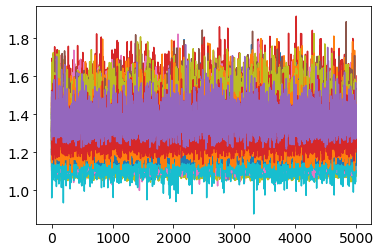

In [31]:
plt.plot(samples['GR1_ind']);

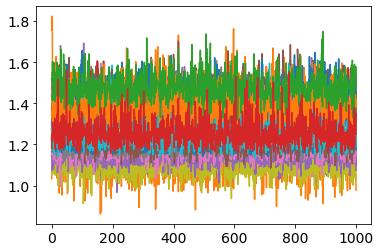

In [122]:
plt.plot(samples['GR1_ind']);

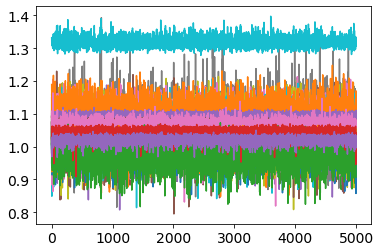

In [32]:
plt.plot(samples['GR2_ind']);

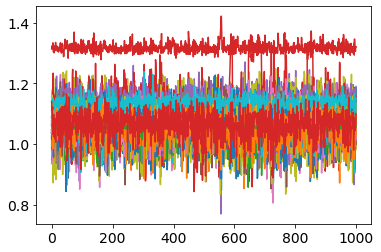

In [103]:
plt.plot(samples['GR2_ind']);

# Parameter Marginals

In [33]:
samples['GR1_ind'].shape

(5000, 55)

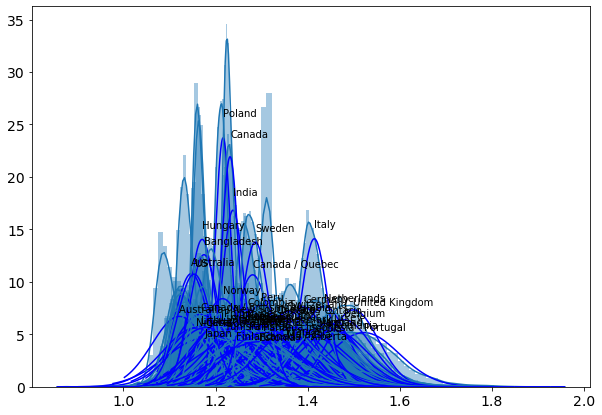

In [60]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(samples['countries']):
    mn = np.mean(samples['GR1_ind'][:,i])
    std = np.std(samples['GR1_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c.decode(), fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR1_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

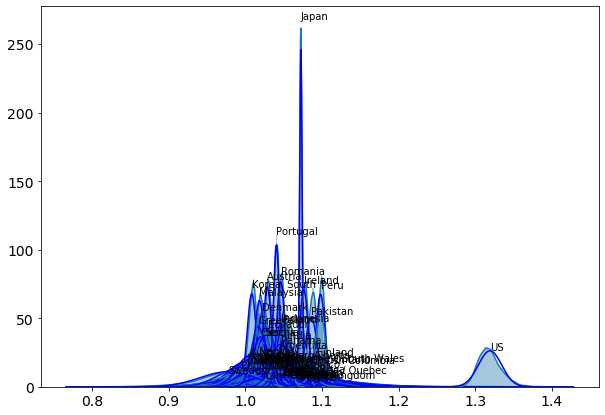

In [35]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR2_ind'][:,i])
    std = np.std(samples['GR2_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR2_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

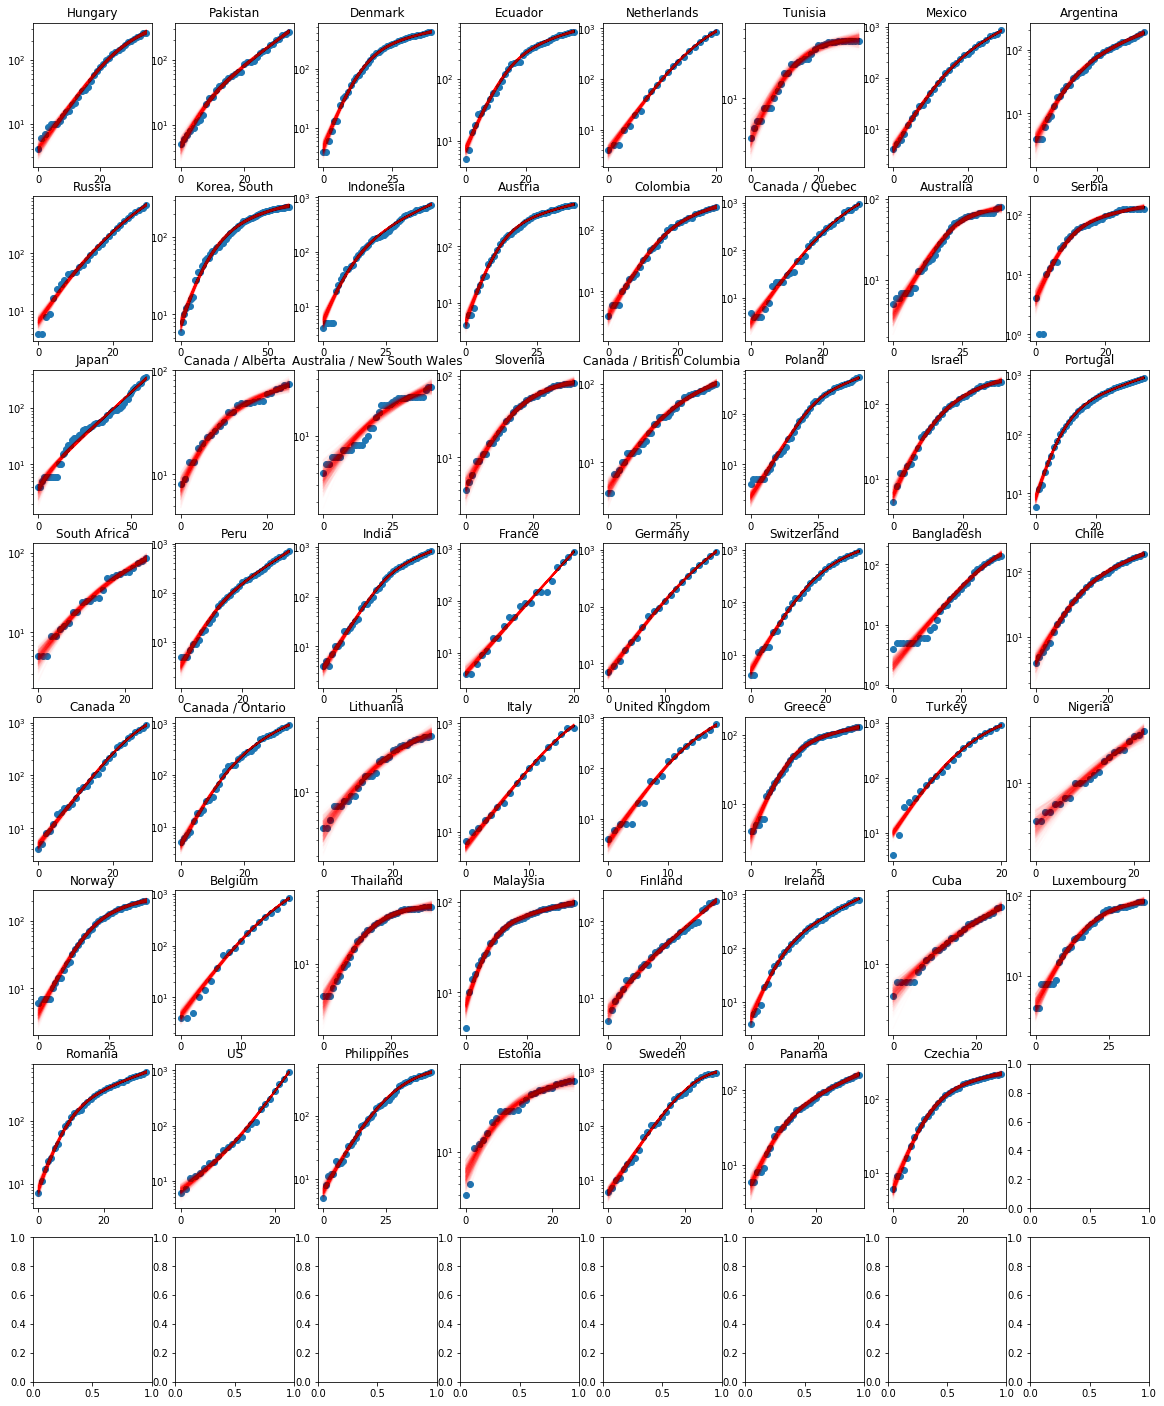

In [37]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(8, 8, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    dead = deaths[c]
    a[i].set_title(c)
    a[i].semilogy(dead, 'o')
    step_inter_vmap = vmap(step_inter)
    predictions = step_inter_vmap(samples['Di_ind'][::10,i], samples['GR1_ind'][::10,i], 
                                  samples['GR2_ind'][::10,i], samples['tr_ind'][::10,i], 
                                  samples['t0_ind'][::10,i])[:,:len(dead)].T
    a[i].semilogy(predictions, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14